In [1]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1920,
        'height': 1080,
        'scroll': True,
})
%config InlineBackend.figure_format = 'retina'

# Week 06, ASTR 596: Fundamentals of Data Science


## Sampling and MCMC

### Gautham Narayan 
##### <gsn@illinois.edu>

Borrowing heavily from David Kirkby and Adam Mantz this week

# <center> HW4 Tips: </center>

### <center> Q1: Read the problem, in particular what I gave you for A. </center>
### <center> Q2: Think about $g(x|x')$ and $g(x'|x)$ for stationary kernels that only depend on $\left|x-x'\right|$ and where you start, how large a step you take.</center>
### <center> Q3: I had you change variables from flux to magnitudes - does the functional form of the model still look the same? </center>


## Recap: Markov Chains

* We've come up with a model, an objective/loss/likelihood function and some priors
* Now we actually want to evaluate the posterior $P(\theta|D)$
    * analytically is too hard, so we draw samples (i.e. **Monte Carlo**) 
        * convert messy integrals to sums over the samples 
* Simple Monte Carlo was wasteful because we don't want to draw samples over all parameter space
    * one way to make it more efficient was make samples that are correlated with each other
        * keep sampling in regions of high probability, don't sample in regions without
        * Markov Chains are series of samples where every sample only depends on the previous one

* Want to setup the problem so the frequency of samples in some region of width $dx$ **is proportional** to some function of $x$
* There are two ways to do this:
    * Rejection sampling - general purpose
    * Inverse Transform sampling - too restrictive, because functions must be invertible
* If we're using rejection sampling to pick samples on our Markov Chain, we're doing **Markov Chain Monte Carlo** with **Metropolis Hastings** as our sampling strategy
    * The **equilibrium** state of this chain is the stationary distribution of samples we desire
    * If the chain isn't in equilibrium, well **tough luck.** Tune more.

## Diagnostics

To be useful to us, a chain must
1. have converged to the posterior distribution
2. provide enough effectively independent samples to characterize it

What would make us confident of convergence?
* Is the chain stationary?
* Do independent chains started from overdispersed positions find the same solution?

How do we guess the number of independent samples?
* Check how well the chain appears to exploring the distribution.
* Compare the autocorrelation length scale with the chain length.

There are numerical estimates that can help with this, but **they are not a substitute for human visual inspection**.

i.e. 
## <center> Look at your data. </center>

### Common misuses of/misconceptions about convergence

Convergence does **not** mean
* that parameters are "well constrained" by the data
* that the autocorrelation length is small
* that there are not occasional excursions beyond a locus in parameter space

# In class exercise:

We need our chains to have two properties:
Which of these chains are a) reversible b) stationary
<table>
    <tr>
        <td><img src="chains.jpg" width=100%></td>
    </tr>
</table>


* How stationary does each sequence appear? 
* Are all chains sampling the same PDF? Compare to what you found for `pgauss` on HW4
<table>
    <tr>
        <td><img src="mc1_sandbox_ab.png" width=100%></td>
    </tr>
</table>

## Convergence tests
* Look at your data! There is no substitute.
* Gelman-Rubin statistic

<table>
    <tr>
        <td><img src="mc1_sandbox_a.png" width=100%></td>
    </tr>
</table>

<table>
    <tr>
        <td><img src="mc1_sandbox_b.png" width=100%></td>
    </tr>
</table>

# Burnin

Conservatively, we might remove the first $\sim500$ steps based on this. This period is called the **burn in**.

# Gelman-Rubin convergence statistic

This approach tests the similarlity of independent chains intended to sample the same PDF. To be meaningful, **they should start from different locations and burn-in should be removed.**

For a given parameter, $\theta$, the $R$ statistic compares the variance across chains with the variance within a chain. Intuitively, if the chains are random-walking in very different places, i.e. not sampling the same distribution, $R$ will be large.

In detail, given chains $J=1,\ldots,m$, each of length $n$,


## $$B=\frac{n}{m-1} \sum_j \left(\bar{\theta}_j - \bar{\theta}\right)^2$$

where $\bar{\theta_j}$ is the average $\theta$ for chain $j$ and $\bar{\theta}$ is the global average. This is proportional to the variance of the individual-chain averages for $\theta$.


## $$W=\frac{1}{m}\sum_j s_j^2$$

where $s_j^2$ is the estimated variance of $\theta$ within chain $j$. 
This is the average of the individual-chain variances for $\theta$.

## $$V=\frac{n-1}{n}W + \frac{1}{n}B$$
This is an estimate for the overall variance of $\theta$.

Finally, 

## $$R=\sqrt{\frac{V}{W}}$$

We'd like to see $R\approx 1$ (e.g. $R<1.1$ is often used).

Note that this calculation can also be used to track convergence of combinations of parameters, or anything else derived from them.

Iff $R\approx 1$, then the chains are described as **well mixed.**

We also gave up a nice property of Simple Monte Carlo moving to Markov Chain Monte Carlo. Our samples are now correlated - i.e. you literally took a position and adjusted it by a small amount. This means that when you request 10,000 samples from Metropolis Hastings, you aren't actually getting 10,000 samples because they aren't **independent**.

### Correlation tests
* Look at your data! Again, no substitute.
* Autocorrelation of parameters

Do subsequent samples look particularly independent?
<table>
    <tr>
        <td><img src="mc1_sandbox_a.png" width=100%></td>
    </tr>
</table>

The **autocorrelation** of a sequence (**after** removing burn-in), as a function of lag, $k$, is:

## $$\rho_k = \frac{\sum_{i=1}^{n-k}\left(\theta_{i} - \bar{\theta}\right)\left(\theta_{i+k} - \bar{\theta}\right)}{\sum_{i=1}^{n-k}\left(\theta_{i} - \bar{\theta}\right)^2} = \frac{\mathrm{Cov}_i\left(\theta_i,\theta_{i+k}\right)}{\mathrm{Var}(\theta)}$$

The larger lag one needs to get a small autocorrelation, the less informative individual samples are.

The `pandas` function `autocorrelation_plot()` may be useful for this.

<table>
    <tr>
        <td><<img src="mc1_sandbox_acf-a.png" width=100%></td>
    </tr>
</table>

<table>
    <tr>
        <td><img src="mc1_sandbox_acf-b.png" width=100%></td>
    </tr>
</table>

Note that the positive/negative oscillations basically tell us when the lag is so large compared with the chain length that the autocorrelation is too noisy to be meaningful.

We would be justified in **thinning** the chains by a factor of ∼150, apparently! (i.e. take every 150th sample)

### Effective number of samples

From $m$ chains of length $n$, we can estimate the effective number of independent samples as

## $$n_{eff} = \frac{mn}{1+2\sum_0^\infty \hat{\rho}_t}$$

with

## $$\hat{\rho}_t = 1 - \frac{V_t}{2V}$$

($V$ in the denominator as in the Gelman-Rubin calculation)

## $$V_t = \frac{1}{m(n-t)} \sum_{j=0}^m \sum_{i=t+1}^n (\theta_{i,j} - \theta_{i-t,j})^2$$

In practice, the sum in $n_{eff}$ is cut off when the estimates $\hat{\rho}_t$ become too noisy (see references).

## In class exercise: can we declare victory?

In each of the following trace plots, different colors show independent chains. For each decide by inspection whether the following are plausible claims:
1. The chains have converged to the posterior.
2. The chains have a reasonable number of independent samples.

<table>
    <tr>
        <td><img src="mc1_convgame_1.png" width=100%></td>
        <td><img src="mc1_convgame_2.png" width=100%></td>
    </tr><tr>
        <td><img src="mc1_convgame_3.png" width=100%></td>
        <td><img src="mc1_convgame_4.png" width=100%></td>
    </tr>
</table>

Tuning is a kind of boring and painful. And if we're going to start multiple chains anyway, might as well start them all at once.

## Affine-invariant MC (i.e. `emcee`)

* Based on the paper by [Goodman and Weare](https://msp.org/camcos/2010/5-1/p04.xhtml)

* implemented in `emcee`

* many walkers simultaneously generating correlated Markov Chains

* **Affine Invariance** - efficiency not impacted by any linear (aka affine) transformation of the parameter space

This is one of a class of methods that evolve an *ensemble* of states rather than a single state.
After convergence, the ensemble can be regarded as a set of samples from the target distribution.

This approach provides some of the benefits of running multiple chains - but remember that these are not *independent* chains!

### The Goodman-Weare method

The algorithm for moving each point in the ensemble is:
1. Randomly pick a different point from the ensemble (total size $N$).
2. Propose a move in the direction of that point, by the distance between them multiplied by a random from this distribution:
$g(z) \propto \frac{1}{\sqrt z}; ~ \frac{1}{2}\leq z \leq 2$
3. Accept or reject the move based on the ratio of posterior densities multiplied by $z^{N-1}$.

Note that there is some magic in the density $g$. We are not free to choose just any function.

This algorithm is relatively easy to use - there is no tuning required and it's straightforward to parallelize.

Important cautions:
* if the ensemble is not started in a region of high probability, convergence will be **extremely** slow. Y
* as the walkers are not independent, the Gelman-Rubin convergence criterion doesn't apply
* assessing convergence visually is not always straightforward

# In class exercise - Using `emcee` to deal with the HW2 problem

Same idea as HW2 - we have some x, y data with outliers, but rather than use the Huber loss (which was a bit ad hoc)
we'll define a mixture likelihood and then use affine-invariant MCMC to sample the posterior. Critically, this will not have a tuning step! 

In [2]:
# RUN THIS

%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import emcee
import corner
from scipy import optimize

# this just makes plots a bit easier on my laptop - disable as needed
%config InlineBackend.figure_format='retina'


# we'll create x, y, error values
x = np.array([ 0,  3,  9, 14, 15, 19, 20, 21, 30, 35,
              40, 41, 42, 43, 54, 56, 67, 69, 72, 88])
y = np.array([33, 68, 34, 34, 37, 71, 37, 44, 48, 49,
              53, 49, 50, 48, 56, 60, 61, 63, 44, 71])
e = np.array([ 3.6, 3.9, 2.6, 3.4, 3.8, 3.8, 2.2, 2.1, 2.3, 3.8,
               2.2, 2.8, 3.9, 3.1, 3.4, 2.6, 3.4, 3.7, 2.0, 3.5])

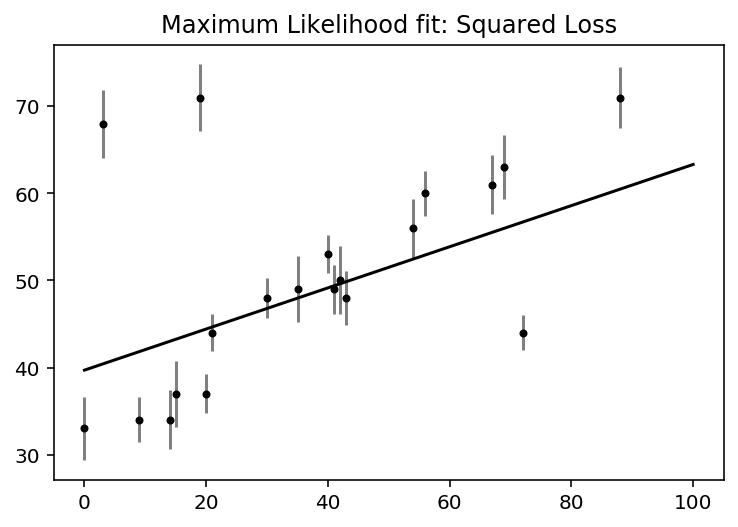

In [3]:
# RUN THIS

# just as before, we can define a simple chisquared function

def squared_loss(theta, x=x, y=y, e=e):
    dy = y - theta[0] - theta[1] * x
    return np.sum(0.5 * (dy / e) ** 2)

theta1 = optimize.fmin(squared_loss, [0, 0], disp=False)

xfit = np.linspace(0, 100)
plt.errorbar(x, y, e, fmt='.k', ecolor='gray')
plt.plot(xfit, theta1[0] + theta1[1] * xfit, '-k')
plt.title('Maximum Likelihood fit: Squared Loss');

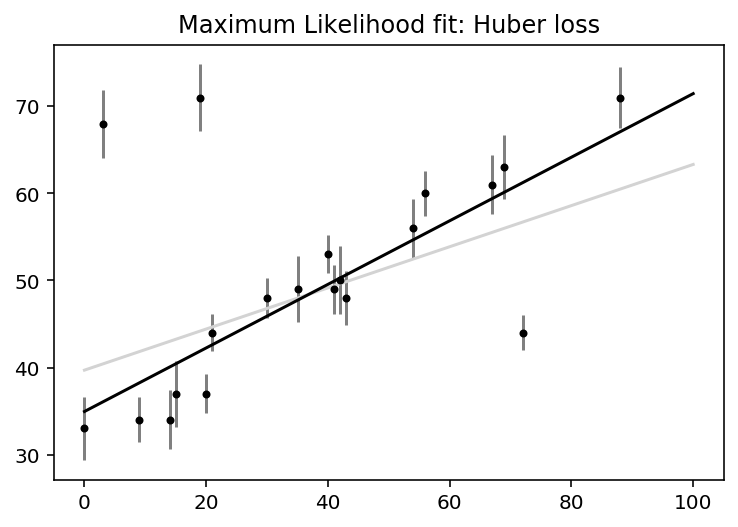

In [4]:
# RUN THIS

# we can also make a Huber loss function as before and get a fit that is more resilient to outliers

def huber_loss(t, c=3):
    return ((abs(t) < c) * 0.5 * t ** 2
            + (abs(t) >= c) * -c * (0.5 * c - abs(t)))

def total_huber_loss(theta, x=x, y=y, e=e, c=3):
    return huber_loss((y - theta[0] - theta[1] * x) / e, c).sum()

theta2 = optimize.fmin(total_huber_loss, [0, 0], disp=False)

plt.errorbar(x, y, e, fmt='.k', ecolor='gray')
plt.plot(xfit, theta1[0] + theta1[1] * xfit, color='lightgray')
plt.plot(xfit, theta2[0] + theta2[1] * xfit, color='black')
plt.title('Maximum Likelihood fit: Huber loss');

The Bayesian approach to accounting for outliers generally involves *modifying the model* so that the outliers are accounted for. For this data, it is abundantly clear that a simple straight line is not a good fit to our data. So let's propose a more complicated model that has the flexibility to account for outliers.

One option is to choose a mixture between a signal and a background:

$$
\begin{array}{ll}
p(\{x_i\}, \{y_i\},\{e_i\}~|~\theta,\{g_i\},\sigma,\sigma_b) = & \frac{g_i}{\sqrt{2\pi e_i^2}}\exp\left[\frac{-\left(\hat{y}(x_i~|~\theta) - y_i\right)^2}{2e_i^2}\right] \\
&+ \frac{1 - g_i}{\sqrt{2\pi \sigma_B^2}}\exp\left[\frac{-\left(\hat{y}(x_i~|~\theta) - y_i\right)^2}{2\sigma_B^2}\right]
\end{array}
$$

What we've done is expanded our model with some nuisance parameters: $\{g_i\}$ is a series of weights which range from 0 to 1 and encode for each point $i$ the degree to which it fits the model. $g_i=0$ indicates an outlier, in which case a Gaussian of width $\sigma_B$ is used in the computation of the likelihood. This $\sigma_B$ can also be a nuisance parameter, or its value can be set at a sufficiently high number, say 50.

This model is a mixture of two Gaussians and is something we'll use a lot when we have multiple underlying populations that we want to model at the same time. We generally call these Gaussian mixture models, because we're really super creative. 

Our model is much more complicated now: it has 22 parameters rather than 2, but the majority of these can be considered nuisance parameters, which can be marginalized-out in the end, just as we marginalized (integrated) over $p$ in the Billiard example.  Let's construct a function which implements this likelihood. As in the previous post, we'll use the [emcee](https://emcee.readthedocs.io/en/stable/) package to explore the parameter space.

To actually compute this, we'll start by:
* defining the model (done implicitly) 
* functions describing our likelihood function (done above) 
* our prior (we'll make this up)
* and posterior (defined once we have likelihood and prior)

And then you get to use `emcee` to sample.

In [5]:
# RUN THIS

# this is a basic choice for prior ( i.e. g_i has to be between 0 and 1)
def log_prior(theta):
    #g_i needs to be between 0 and 1
    if (all(theta[2:] > 0) and all(theta[2:] < 1)):
        return 0
    else:
        return -np.inf  # recall log(0) = -inf

# the likelihood function is the same as we write above, except now as a log
def log_likelihood(theta, x, y, e, sigma_B):
    dy = y - theta[0] - theta[1] * x
    g = np.clip(theta[2:], 0, 1)  # g<0 or g>1 leads to NaNs in logarithm
    logL1 = np.log(g) - 0.5 * np.log(2 * np.pi * e ** 2) - 0.5 * (dy / e) ** 2
    logL2 = np.log(1 - g) - 0.5 * np.log(2 * np.pi * sigma_B ** 2) - 0.5 * (dy / sigma_B) ** 2
    
    # we have the sum of two PDFs that we took the log of
    # to do this when we write those PDFs itself as logs, we can use np.logaddexp
    return np.sum(np.logaddexp(logL1, logL2))

def log_posterior(theta, x, y, e, sigma_B):
    # posterior is product of likelihood and prior (or sum of log likelihoods)
    return log_prior(theta) + log_likelihood(theta, x, y, e, sigma_B)

In [6]:
# Note that this step will take a few minutes to run!

ndim = 2 + len(x)  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 10000  # "burn-in" period to let chains stabilize
nsteps = 15000  # number of MCMC steps to take

# set theta near the maximum likelihood, with 
np.random.seed(10)
starting_guesses = np.zeros((nwalkers, ndim))
starting_guesses[:, :2] = np.random.normal(theta1, 1, (nwalkers, 2))
starting_guesses[:, 2:] = np.random.normal(0.5, 0.1, (nwalkers, ndim - 2))


# YOUR CODE GOES HERE
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[x, y, e, 50])
_ =  sampler.run_mcmc(starting_guesses, nsteps, rstate0=np.random.get_state())

/Users/gnarayan/miniconda3/envs/fds/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/Users/gnarayan/miniconda3/envs/fds/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


In [7]:
sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].reshape(-1, ndim)

In [8]:
# the shape here is (nsteps - nburn)* nwalkers, ndim
sample.shape

(250000, 22)

Once we have these samples, we can exploit a very nice property of the Markov chains. Because their distribution models the posterior, we can integrate out (i.e. marginalize) over nuisance parameters simply by ignoring them!

We can look at the (marginalized) distribution of slopes and intercepts by examining the first two columns of the sample:

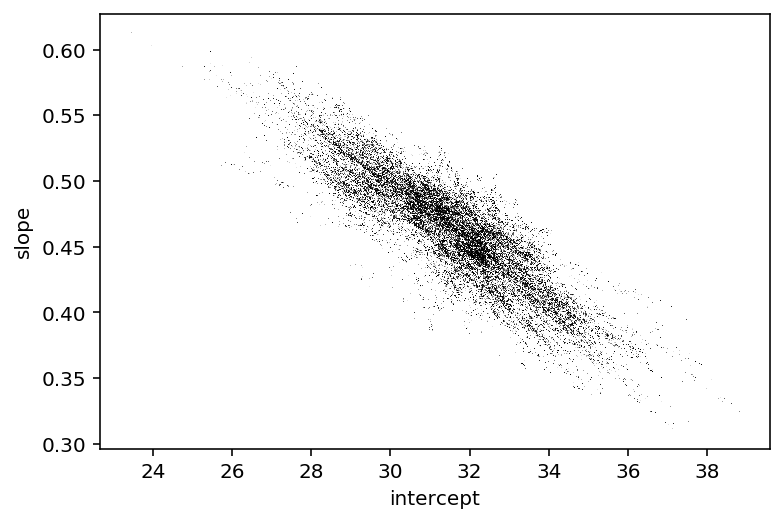

In [9]:
plt.plot(sample[:, 0], sample[:, 1], ',k', alpha=0.1)
plt.xlabel('intercept')
plt.ylabel('slope');

We see a distribution of points near a slope of $\sim 0.45$, and an intercept of $\sim 31$. We'll plot this model over the data below, but first let's see what other information we can extract from this trace.

One nice feature of analyzing MCMC samples is that the choice of nuisance parameters is completely symmetric: just as we can treat the $\{g_i\}$ as nuisance parameters, we can also treat the slope and intercept as nuisance parameters! Let's do this, and check the posterior for $g_1$ and $g_2$, the outlier flag for the first two points:

g1 mean: 0.63
g2 mean: 0.36


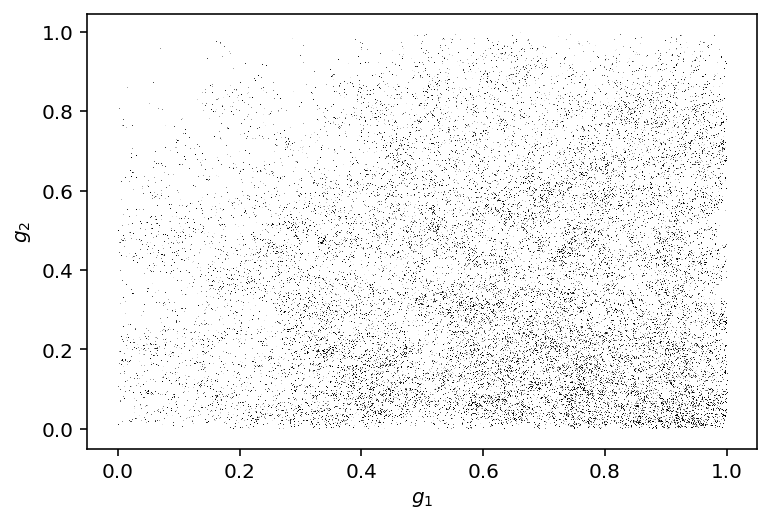

In [10]:
plt.plot(sample[:, 2], sample[:, 3], ',k', alpha=0.1)
plt.xlabel('$g_1$')
plt.ylabel('$g_2$')

print("g1 mean: {0:.2f}".format(sample[:, 2].mean()))
print("g2 mean: {0:.2f}".format(sample[:, 3].mean()))

There is not an extremely strong constraint on either of these, but we do see that $(g_1, g_2) = (1, 0)$ is slightly favored: the means of $g_1$ and $g_2$ are greater than and less than 0.5, respecively. If we choose a cutoff at $g=0.5$, our algorithm has identified $g_2$ as an outlier.

Let's make use of all this information, and plot the marginalized best model over the original data. As a bonus, we'll draw red circles to indicate which points the model detects as outliers:

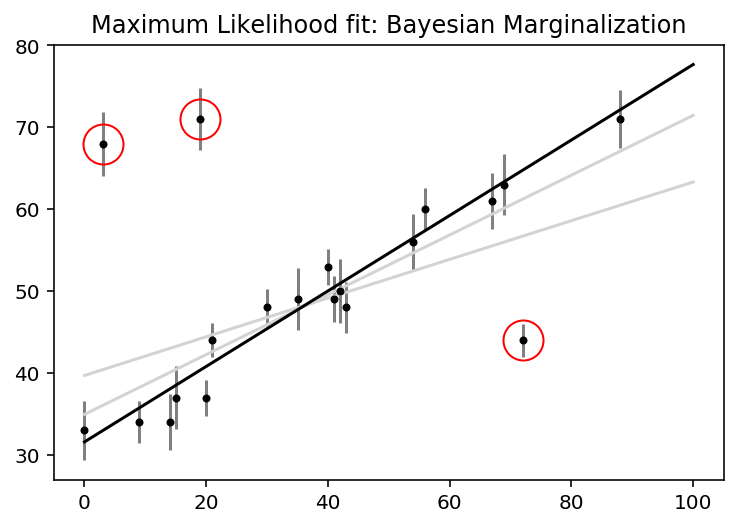

In [11]:
theta3 = np.mean(sample[:, :2], 0)
g = np.mean(sample[:, 2:], 0)
outliers = (g < 0.5)

plt.errorbar(x, y, e, fmt='.k', ecolor='gray')
plt.plot(xfit, theta1[0] + theta1[1] * xfit, color='lightgray')
plt.plot(xfit, theta2[0] + theta2[1] * xfit, color='lightgray')
plt.plot(xfit, theta3[0] + theta3[1] * xfit, color='black')
plt.plot(x[outliers], y[outliers], 'ro', ms=20, mfc='none', mec='red')
plt.title('Maximum Likelihood fit: Bayesian Marginalization');

* regularization
    * bias-variance tradeoff
        
* gibbs sampling
    * conjugate priors -> PIT
* PT -> simmulated annealing 